# Did they receive a flu vaccine?
by Michael Kearns

# Business Understanding

The company is prepping for the upcoming flu season. The production team wants to determine how many vaccines they need to produce to avoid over spending and reduce waste. To determine this, the plan is to gather information from a sample of individuals and classify how many of them will receive the vaccine. Previous data has been gathered on indiviauls with different behaviors and beliefs and whether they had received the flu vaccine in the past. By building a classification model on the previous data, this model can be used to make future classifications and predictions.

# Data Understanding

After the outbreak of the H1N1 virus, the United states conducted the National 2009 H1N1 Flu Survey. This data collected whether individuals received the H1N1 or seasonal flu vaccine as well as information on their backgrounds and health behaviors. For the purpose of this model, the data will only be used to classify if someone received the seasonal flu vaccine. 

Features of this data are primarily formatted in a binary fasion, where 1 - 'Yes' and 0 - 'No'. Multiple features are object type that will require dummy variables or one hot encoding to be considered in the model.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np 

In [2]:
#Data source provided two .csv files. 
#The 'training_set_labels.csv' contains the target value, whether a person recevied the seasonal flu vaccine
#The 'training_set_features.csv' contains the multiple features about each respondent.

train_set_features = 'data/training_set_features.csv'
train_set_labels = 'data/training_set_labels.csv'

In [3]:
#Create dataframe from each .csv file.

features = pd.read_csv(train_set_features)
labels = pd.read_csv(train_set_labels)

df = labels.merge(features,how = 'outer', on = 'respondent_id')

In [4]:
#Remove columns related to H1N1
h1n1_cols_delete = ['h1n1_concern','h1n1_knowledge', 
               'doctor_recc_h1n1',
               'opinion_h1n1_vacc_effective', 
               'opinion_h1n1_risk',
               'opinion_h1n1_sick_from_vacc',
                'h1n1_vaccine']
               

data_flu = df.drop(h1n1_cols_delete, axis = 1)

In [5]:
data_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_seasonal         24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  health_insurance

In [6]:
#Remove sensitive features from dataset
cols_sensitive = list(data_flu.columns)[17:]
data_flu_clean = data_flu.drop(cols_sensitive,axis = 1)

In [7]:
#Determine which features are missing a lot of data and remove feature from dataset.
data_flu_clean.isna().mean()
data_flu_clean2 = data_flu_clean.drop('health_insurance',axis = 1)

In [8]:
#Remove rows that is missing data.
data_cleaned = data_flu_clean2.dropna(axis = 0)

# Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt

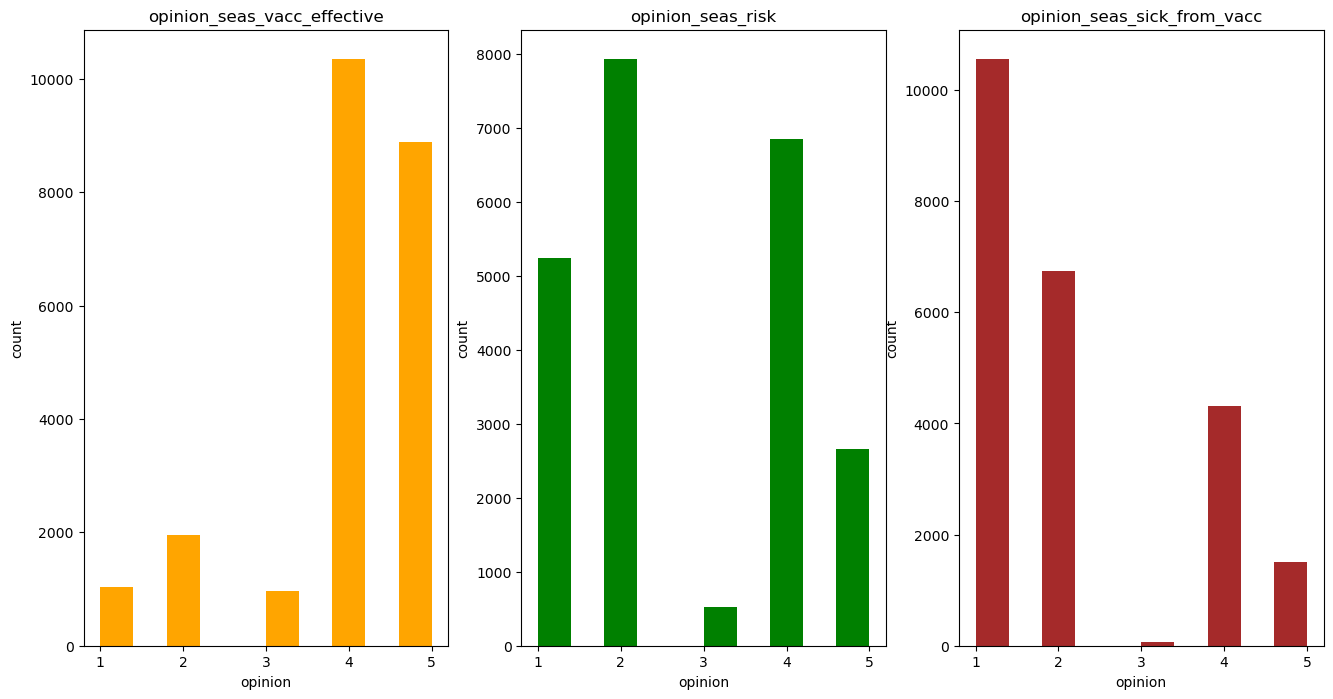

In [10]:
health_opinions = ['opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc']
colors = ['orange','green','brown']
j = len(health_opinions)
fig, axes = plt.subplots(1,j,figsize = (16,8))
for i in range(0,j):
    axes[i].hist(data_cleaned[health_opinions[i]],color = colors[i])
    axes[i].set_title(health_opinions[i])
    axes[i].set_ylabel('count')
    axes[i].set_xlabel('opinion')

People's opinions about the seasonal flu vaccine appears to be variable. Therefore this will be a good feature to use in the ML model.

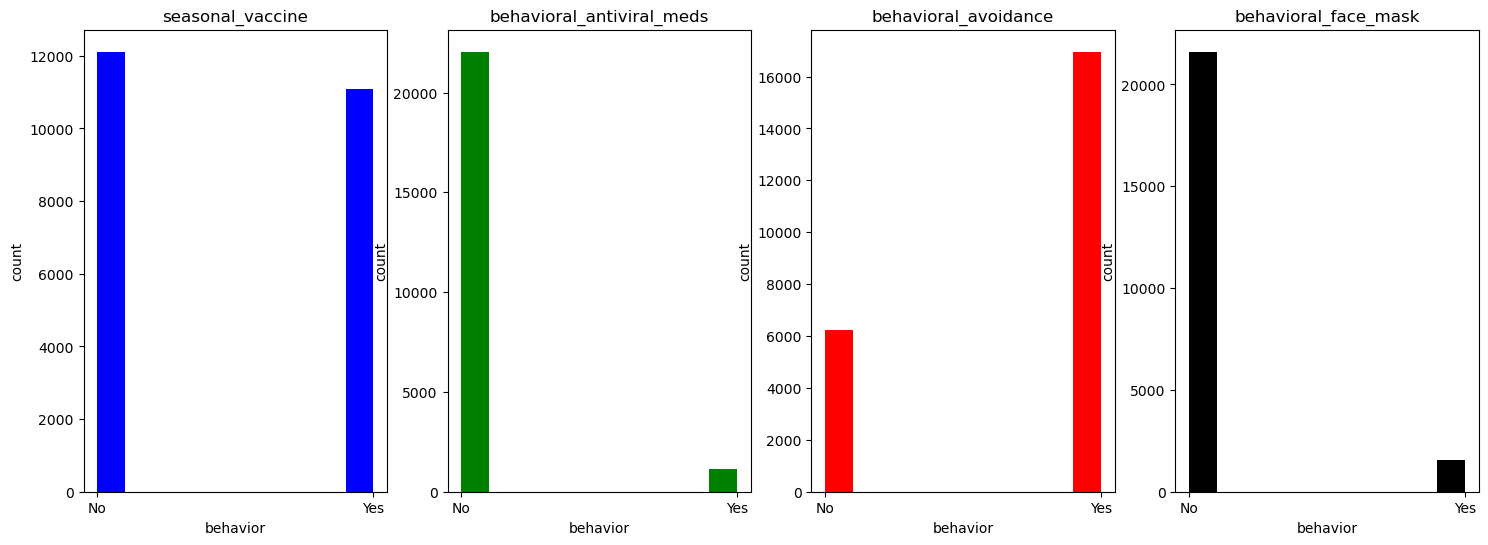

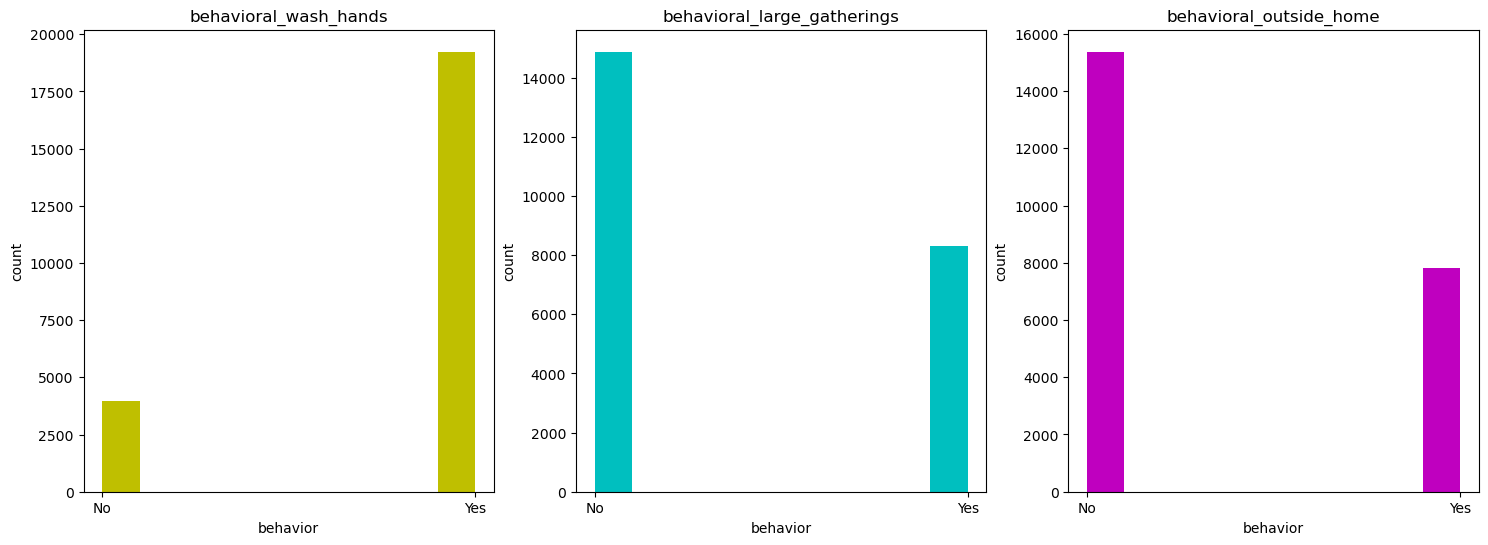

In [11]:
health_behaviors = data_cleaned.columns.tolist()[1:8]
colors = ['b','g','r','k','y','c','m']
fig, axes = plt.subplots(1,4,figsize = (18,6))
for i in range(0,4):
    axes[i].hist(data_cleaned[health_behaviors[i]],color = colors[i])
    axes[i].set_title(health_behaviors[i])
    axes[i].set_ylabel('count')
    axes[i].set_xlabel('behavior')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['No','Yes'])
fig, axes = plt.subplots(1,3,figsize = (18,6))
for i in range(4,7):
    axes[i-4].hist(data_cleaned[health_behaviors[i]],color = colors[i])
    axes[i-4].set_title(health_behaviors[i])
    axes[i-4].set_ylabel('count')
    axes[i-4].set_xlabel('behavior')
    axes[i-4].set_xticks([0,1])
    axes[i-4].set_xticklabels(['No','Yes'])

People's health behaviors tend to lean more towards one action than the other. This will still be an interesting feature to include.

# ML Modeling

In [12]:
data = pd.get_dummies(data_cleaned,columns = health_opinions,drop_first=True,dtype=float)


In [13]:
#Check if there is an imbalance in target values

print(data['seasonal_vaccine'].value_counts())
print('No class imbalance in target value')

seasonal_vaccine
0    12111
1    11077
Name: count, dtype: int64
No class imbalance in target value


## Target

The goal of this model is to be able to classify whether an individual will receive the seasonal flu vaccine based on their health behaviors and opinions. This information will help the company determine how many vaccines to produce. From this model, a 'False Positive' would represent identifying someone that will choose to receive the vaccine but in fact they do not. A 'False Negative' would represent identifying someone that will choose to not receive the vaccine but they do receive it. It may be costly to over produce vaccines, but there is a greater social and medical impact if there are not enough vaccines for those who choose to receive one. Therefore, minimizing the number of 'False Negatives' is important and Recall will the evaluation metric used for this model

### Baseline Model - Logistic Regression Model

In [14]:
from sklearn.model_selection import train_test_split

X = data[data.columns.to_list()[2:]]
y = data['seasonal_vaccine']

/Users/michaelkearns/anaconda3/envs/my-learn-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
#perform split with sklearn train_test_split
#Set a random state, and assign 80% of date to test group.

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42,test_size = 0.8)

In [16]:
from sklearn.linear_model import LogisticRegression

#instantiate baseline model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
#fit to train data
logreg.fit(X_train, y_train)



LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [17]:
#Generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)


In [18]:
from sklearn.metrics import recall_score

print('Baseline - Training Recall: ', recall_score(y_train, y_hat_train))
print('Baseline - Testing Recall: ', recall_score(y_test, y_hat_test))

Baseline - Training Recall:  0.7391304347826086
Baseline - Testing Recall:  0.7429346597332127


Recall numbers on Training data and testing data are similar. This shows that the model is not overfitting to the training data. Ideally though the model performs better with better recall values. A 74% recall number means that of all the people who received the flu vaccine, 74% of them were correctly identified. 

### Model 2 - Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

dtc = DecisionTreeClassifier(random_state = 10)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [20]:
#Generate predictions
y_hat_train = dtc.predict(X_train)
y_hat_test = dtc.predict(X_test)

#Check metrics of model
print('Decision Tree - Training Recall: ', recall_score(y_train, y_hat_train))
print('Decision - Testing Recall: ', recall_score(y_test, y_hat_test))

Decision Tree - Training Recall:  0.8323621694307486
Decision - Testing Recall:  0.658376667420303


The Decision tree model improved on the training data, but was worse on the test data. This shows that model is overfitting to the training data and cannot predict as well on the test data.

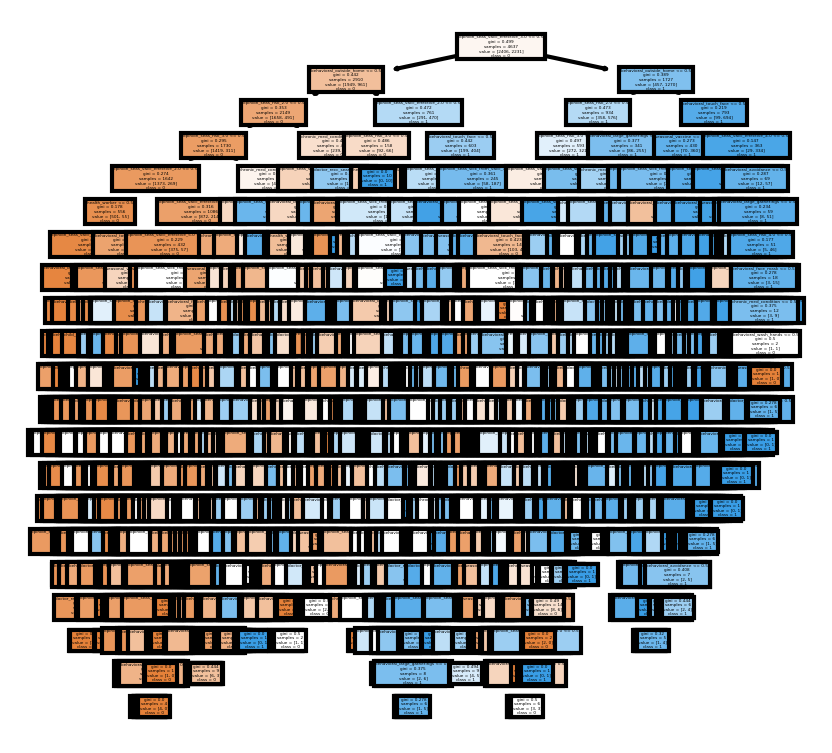

In [21]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(dtc,
               feature_names = data.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

This model is too complex, perhaps it can be simiplified and tuned to reduce overfitting.

In [22]:
dtc.tree_.max_depth

20

### Model 3

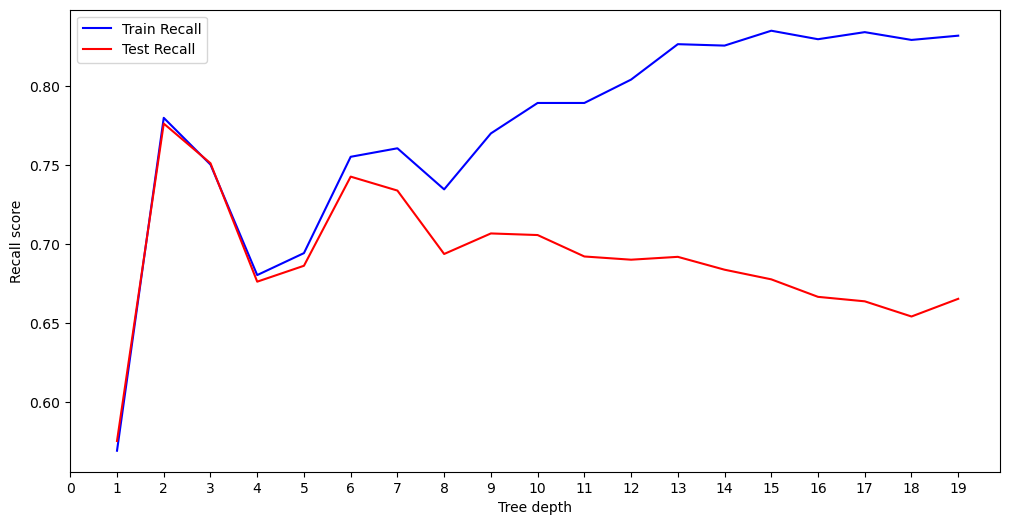

In [23]:
#Check Optimal depth
dt_depth = dtc.tree_.max_depth

max_depth = list(range(1, dt_depth))
train_results = []
test_results = []
for depth in max_depth:
    
    dt = DecisionTreeClassifier(max_depth=depth, random_state=10)
    dt.fit(X_train,y_train)
    #Test Results
    test_y_pred = dt.predict(X_test)
    test_recall = recall_score(y_test, test_y_pred)
    test_results.append(test_recall)
    #Train Results
    train_y_pred = dt.predict(X_train)
    train_recall = recall_score(y_train, train_y_pred)
    train_results.append(train_recall)
    
plt.figure(figsize=(12,6))
plt.plot(max_depth, train_results, 'b', label='Train Recall')
plt.plot(max_depth, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('Tree depth')
plt.xticks(np.arange(0, dt_depth, step=1))
plt.legend()
plt.show()

Try depth of 6.

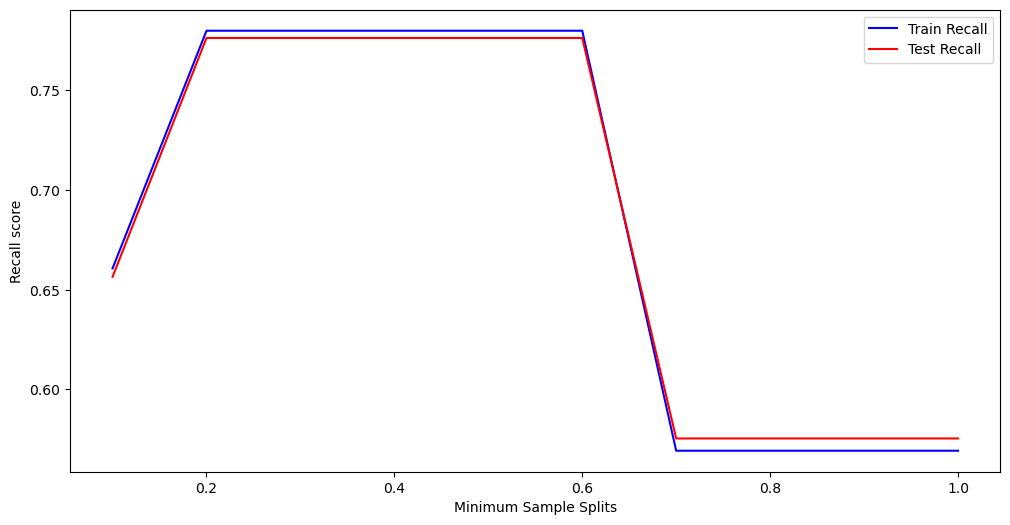

In [24]:
# Identify the optimal min-samples-split for given data
sample_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for num in sample_splits:
    dt = DecisionTreeClassifier(min_samples_split=num, random_state=10)
    dt.fit(X_train,y_train)
    #Test Results
    test_y_pred = dt.predict(X_test)
    test_recall = recall_score(y_test, test_y_pred)
    test_results.append(test_recall)
    #Train Results
    train_y_pred = dt.predict(X_train)
    train_recall = recall_score(y_train, train_y_pred)
    train_results.append(train_recall)

plt.figure(figsize=(12,6))
plt.plot(sample_splits, train_results, 'b', label='Train Recall')
plt.plot(sample_splits, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('Minimum Sample Splits')
plt.legend()
plt.show()

0.6 is the optimal minimum sample split

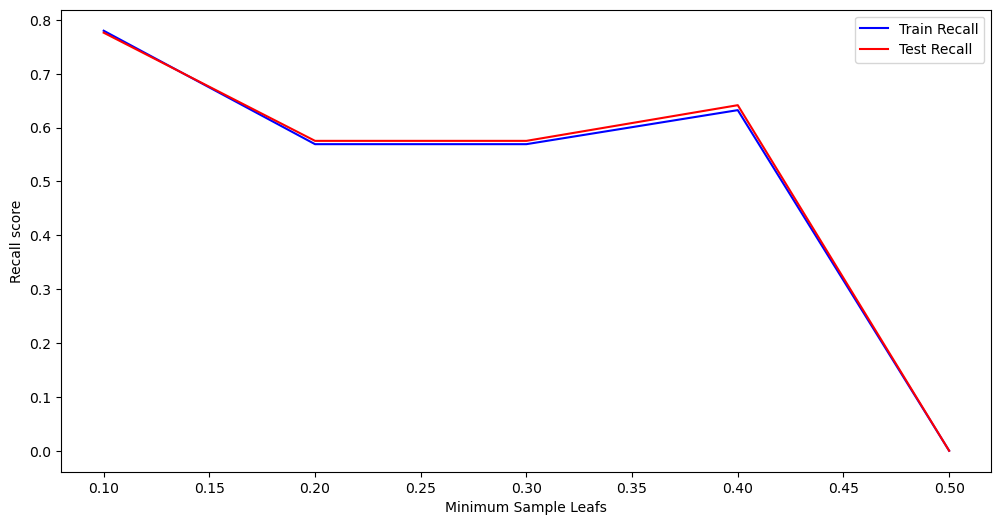

In [25]:
# Calculate the optimal value for minimum sample leafs
sample_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for num in sample_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=num, random_state=10)
    dt.fit(X_train,y_train)
    #Test Results
    test_y_pred = dt.predict(X_test)
    test_recall = recall_score(y_test, test_y_pred)
    test_results.append(test_recall)
    #Train Results
    train_y_pred = dt.predict(X_train)
    train_recall = recall_score(y_train, train_y_pred)
    train_results.append(train_recall)

plt.figure(figsize=(12,6))
plt.plot(sample_leafs, train_results, 'b', label='Train Recall')
plt.plot(sample_leafs, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('Minimum Sample Leafs')
plt.legend()
plt.show()

Minimum sample leafs value of 0.1 is the most optimal.

In [26]:
#Make Decision Tree Model with tuned parameters.

dtc = DecisionTreeClassifier(random_state = 10,
                            max_depth=6,
                            min_samples_split=0.6,
                            min_samples_leaf=0.1)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.1, min_samples_split=0.6,
                       random_state=10)

In [27]:
#Generate predictions
y_hat_train = dtc.predict(X_train)
y_hat_test = dtc.predict(X_test)

#Check metrics of model
print('Decision Tree - Training Recall: ', recall_score(y_train, y_hat_train))
print('Decision - Testing Recall: ', recall_score(y_test, y_hat_test))

Decision Tree - Training Recall:  0.7799193186911699
Decision - Testing Recall:  0.7762830657924485


Model is no longer overfitting. Recall score dropped slightly but this is performing better compared to the baseline logistic regression model.

# Conclusions

## Recommendations

## Limitations

## Next Steps